# 上市公司2021年第二季EPS公開資訊- ***<span style='color:red'>Python爬蟲專案</span>***  

> 以Python程式擷取[公開資訊觀測站](https://mops.twse.com.tw/mops/web/index)網頁中的上市公司綜合損益表   
> 將會用到python 資料處理模組**pandas dataframe**的功能包括:  
> - 網頁爬取與分析(read_html)
> - 建立
> - 選取(iloc, column name)
> - 篩選(filter)
> - 迴圈處理(enumerate)
> - csv檔案輸出(to_csv)

| Robert Lin <nobodybutyou.lin@gmail.com> 

---  
## 綜合損益表所在選單路徑  
在公開資訊觀測站有關上市公司的綜合損益表的表單選取路徑如下圖所示  

<img src="incomeStmtPath.jpg">

## 程式碼與說明  

首先我們將會用到模組匯入, 包括資料處理模組**pandas**, 數字運算與統計模組**numpy及statistics**, 我們也會利用**matplotlib**的繪圖功能且會用到中文字型, 所以會納入**pyplot及fontmanager裡的FontProperites**

In [1]:
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

### 資料爬取
接下來我們要透過Chrome瀏覽器來觀察, 在**綜合損益表的畫面中**, 瀏覽器如何丟出我們的報表需求, 以取得回應文件, 我們可在綜合損益表的畫面中先**點選滑鼠右鍵**,在選取**檢查**, 即可錄取瀏覽器的畫面取得過程, 我們以選取**上市公司110年第二季**報表為例, 操作畫面如下

<img src="incomeStmtPost1.jpg">

觀察開發工具中Network底下的Fetch/XHR選取發出的URL請求https://mops.twse.com.tw/mops/web/t163sb04 以及其傳送的參數內容, 截取的過程畫面如下, 可以看到傳送的參數包括**encodeURIComponent=1, step=1, firstin=1, off=1, isQuery=Y, TYPEK=sii, year=110, season=02,** 因此我們可以利用pandas中既有的**read_html**來模擬瀏覽器發出抓取指定內容的請求, 而且read_html的好處是可以將回應的html文建中以<table tag建立的表格內容, 依據<th tag標題欄及<tr tag內容欄, 直接**將回應內容內的表格內容值拆分並以dataframe格式回傳**

<img src="incomeStmtPost2.jpg">  

模擬瀏覽器抓取指定損益表的程式碼如下, 因為畫面是中文網頁, 所以read_html必須指定**utf-8**的編碼格式, 避免中文亂碼

In [2]:
# Return Read HTML tables into a list of DataFrame objects.
# This function searches for <table> elements and only for <tr> and <th> rows
# and <td> elements within each <tr> or <th> element in the table.
urlStr = 'https://mops.twse.com.tw/mops/web/ajax_t163sb04?'
paraStr = 'encodeURIComponent=1&step=1&firstin=1&off=1&isQuery=Y&TYPEK=sii&year=110&season=02'

# findout the header row and index_col after check the result html
dfs = pd.read_html(urlStr+paraStr, header=0, index_col=0, encoding='utf-8')

### 數據整理
上市公司損益表回應的內容, 分成好多張<table, 真正的報表數值在**第二張<table**開始, 損益表的<table6張, 這**6張表格**的欄位數並未統一, 但是慶幸的是, 我們關心的基本每股盈餘EPS, 都在表格的**最後一欄**, read_html會將每個<table轉成一個dataframe, 所以我們會取得多個dataframe, 我們可以透過dataframe的**shape**[1]方法,取得每個dataframe的欄數, 另外我們可以先將各個dataframe透過**to_csv**的方法, 將損益表數據轉出成csv檔 

In [3]:
dfEpsCol=[None]*7
# https://www.delftstack.com/howto/python/python-for-loop-multiple-variables/
# Note: each table in html may have different number of cols, but the eps col all in the last one col
# Real data info are starting from table 1
for i, df in enumerate(dfs):
    if i != 0:
        df.to_csv('pdhtmlIncomeStatement'+str(i)+'.csv')
        dfEpsCol[i]=df.shape[1]
print("dfEpsCol=\n", dfEpsCol)

dfEpsCol=
 [None, 21, 21, 29, 21, 22, 17]


第二張Dataframe轉出的csv輸出檔範例如下

<img src="incomeStmtTbl1.jpg">

接下來我們要將6個分開的dataframe串成一張dataframe以便後續的數據處理與分析, 我們在讀取html的時候已經指定header row及index column, 這兩個都不會納入iloc中使用的row index和column index計算中, 新的dataframe dfReqs我們只取出公司名稱和基本每股盈餘, 股號是index, 欄位名稱會繼續沿用

In [4]:
# use df.iloc[rowIndexRange, colInexRange] to select rows and columns
dfReqs = pd.DataFrame()
for i, df in enumerate(dfs):
    if i != 0:
        # Handing first row
        newheader = df.iloc[0:1, [0,df.shape[1]-1]] # can be used for further usage
        #print('newheader={}\n, newheader.info()={}\n'.format(newheader, newheader.info))
        dfReqs=pd.concat([dfReqs,newheader])

        # note how to include the column index
        # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
        newdf = df.iloc[1:df.shape[0],[0,df.shape[1]-1]]
        dfReqs= pd.concat([dfReqs,newdf])
#print('dfReqs=\n', dfReqs)

合併後新的dataframe輸出如下

<img src="incomeStmtMerge.jpg">

### 數據分析
整理完資料後, 再來就可以玩一玩好玩的東西, 例如透過描述性統計來了解一下上市公司Q2 EPS的概況如何, 例如中位數median, percentiled中的1/4位數, 3/4位數, 最大值max, 最小值min等等, 也可列出最虧的公司和最賺的公司

In [5]:
# dataframe的統計工具
#https://blog.csdn.net/weixin_35973118/article/details/112148632
print('EPS中位數={}\n'.format(statistics.median(dfReqs.iloc[:,1])))
# https://numpy.org/doc/stable/reference/generated/numpy.percentile.html
# 取四分位數
lowQ=np.percentile(dfReqs.iloc[:,1], 25)
highQ=np.percentile(dfReqs.iloc[:,1], 75)
minV=dfReqs.iloc[:,1].min()
maxV=dfReqs.iloc[:,1].max()

print('1/4位數={}, 3/4位數={}\n'.format(lowQ, highQ))
print('最小值={}, 最大值={}\n'.format(minV, maxV))
#dataframe filter
print(dfReqs[dfReqs.iloc[:,1]==minV])
print(dfReqs[dfReqs.iloc[:,1]==maxV])

EPS中位數=1.12

1/4位數=0.32, 3/4位數=2.57

最小值=-5.22, 最大值=61.69

     公司名稱  基本每股盈餘（元）
公司代號                
2424   隴華      -5.22
     公司名稱  基本每股盈餘（元）
公司代號                
3008  大立光      61.69


也可找出虧錢(EPS<0)的公司有哪些? 最賺錢的前十大公司是哪些? 當資料量列數很大時, python print只會列出前面幾列及最後面幾列, 中間會被省略, 若要列出dataframe所有列數資料, 可透過dataframe的**set_option**做設定

In [6]:
pd.set_option('display.max_rows', None)
print('2021 Q2 EPS 小於0的公司\n', dfReqs[dfReqs.iloc[:,1]< 0] )

#DataFrame.sort_values(by, axis=0, ascending=True,
#  inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
dfReqs.sort_values(by='基本每股盈餘（元）', ascending=False, inplace=True)
print('2021 Q2 EPS前十大\n',dfReqs.head(10))

2021 Q2 EPS 小於0的公司
         公司名稱  基本每股盈餘（元）
公司代號                   
1103      嘉泥      -0.45
1213      大飲      -0.65
1235      興泰      -0.34
1236      宏亞      -0.11
1315      達新      -1.77
1316      上曜      -0.27
1324      地球      -0.04
1337   再生-KY      -0.77
1340   勝悅-KY      -1.25
1418      東華      -3.58
1432     大魯閣      -1.15
1435      中福      -0.32
1438    三地開發      -0.13
1441      大東      -0.07
1445      大宇      -0.10
1465      偉全      -0.25
1467      南緯      -0.25
1471      首利      -0.61
1472     三洋紡      -0.15
1473      台南      -0.54
1506      正道      -0.12
1512      瑞利      -0.23
1538      正峰      -1.14
1568      倉佑      -0.08
1626  艾美特-KY      -0.53
1721      三晃      -0.14
1724      台硝      -0.02
1805      寶徠      -0.21
1806      冠軍      -0.43
2102      泰豐      -3.08
2241     艾姆勒      -0.21
2243   宏旭-KY      -0.95
2314      台揚      -0.84
2323      中環      -0.41
2331      精英      -0.22
2332      友訊      -0.24
2349      錸德      -0.25
2363      矽統      -0.24
2380      虹光      -0

另外, 我們也可以用直方圖histogram來繪製EPS分佈, 以便視覺化顯示上市公司Q2 EPS的分布狀況, 但是因為Git hub無法處理字型檔, 就先暫時不要用中文字

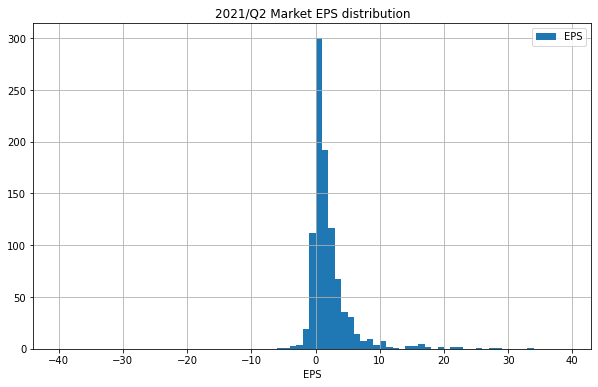

In [7]:
#Specify a correct traditional chinese font
#myfont = FontProperties(fname=r'../noto-cjk/NotoSansCJK-Black.ttc')

# plot the profit rate histogram of all companies in market
fig = plt.figure(figsize=(10, 6))
#plt.xlabel('EPS', fontproperties=myfont)
plt.xlabel("EPS")
#plt.title('2021年Q2 上市公司EPS分佈', fontproperties=myfont)
plt.title('2021/Q2 Market EPS distribution')
# dataframe的hist會回傳histograms直方圖
dfReqs.iloc[:, 1].hist(bins=range(-40,40) , label="EPS")
#plt.legend(prop=myfont)
plt.legend()

## 後記
完成後才發現python另外有個**互動式的繪圖模組plotly**可以使用, 直接將dataframe丟入plotly模組的繪圖功能呼叫, 並指定要用來繪圖的數據欄位後, 就可產出圖形, 以boxplot為例, **將滑鼠移入繪出的圖形還可顯示描述性統計**的相關數據包括最大值, 最小值, 1/4位數, 3/4位數, 中位數等
在JuypterLab或Jupyter Notebook使用plotly, 必須另外透過pip或conda安裝套件, 相關的詳細步驟可見參考資料8, 9 內的連結
參考的程式碼如下:  
`import plotly.express as px`  
`fig = px.box(dfReqs, y="基本每股盈餘（元）")`  
`fig.show()`  

繪出的圖形如下

<img src="epsboxplotplotly.jpg">

##  參考資料
1.[Python.org官方教學網站](https://docs.python.org/zh-tw/3/tutorial/)提供一系列python值得一提的功能與特色與使用方式  

2.[Pandas API參考文件](https://pandas.pydata.org/docs/reference/index.html)查詢datafram各種標準用法及範例, 例如
[read_html](https://pandas.pydata.org/pandas/docs/stable/reference/api/pandas.read_html.html),
[iloc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html)

3.[Akash NS的Python資料分析與資料視覺化教程](https://www.freecodecamp.org/news/exploratory-data-analysis-with-numpy-pandas-matplotlib-seaborn/)介紹python資料分析的一系列常用功能  

4.[Yao-Jen Kuo的輕鬆學Python](https://medium.com/datainpoint/tagged/python)示範了在線執行Python的mybinder.org的功能,及一系列python使用方法範例

5.[Stackoverflow有關在mybinder中顯示import ModuleNotFoundError的解法](https://stackoverflow.com/questions/61858062/install-pandas-for-jupyter-notebook-in-binder)提供在github repository根目錄中提requirementst.txt的參考範例

6.[LeeMeng的Pandas實戰手冊](https://leemeng.tw/practical-pandas-tutorial-for-aspiring-data-scientists.html#)提供40個pandas數據模組快速實用的參考用法  

7.[Markdown語言網站](https://markdown.tw/)查詢更多詳細用法  

8.[Plotly Quickstart](https://pypi.org/project/plotly/)提供plotly模組啟用安裝及小案例

9.[Plotly Examples](https://plotly.com/python/)提供plotly模組各種圖形使用案例